In [17]:

import os 
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import ta
import talib
from statsmodels.tsa.stattools import adfuller
import vectorbt as vbt 


from technical_analysis import *
from ALGO_KT1 import Preprocessing_functions as prf


ticker = "JPM"
df = prf.downlaod_symbol_data(ticker, period = "240mo")

#df = pd.read_csv('crypto_data/ETHUSD_60_v1.csv')
#df.columns = df.columns.str.capitalize()

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,open_low,open_close,open_high,high_low,low_close,high_close,gap
Date,,,,,,,,,,,,,,
2004-06-18 00:00:00-04:00,21.70,21.85,21.54,21.60,12953300,0.0,0.0,0.737327,0.460829,-0.691244,1.418764,-0.278552,-1.144165,NaN
2004-06-21 00:00:00-04:00,21.58,21.69,21.41,21.47,5511700,0.0,0.0,0.787766,0.509731,-0.509731,1.290917,-0.280243,-1.014292,-0.092593
2004-06-22 00:00:00-04:00,21.47,21.48,21.29,21.44,9628200,0.0,0.0,0.838379,0.139730,-0.046577,0.884544,-0.704556,-0.186220,0.000000
2004-06-23 00:00:00-04:00,21.52,21.83,21.51,21.83,9303600,0.0,0.0,0.046468,-1.440520,-1.440520,1.465873,-1.487680,0.000000,0.373134
2004-06-24 00:00:00-04:00,21.83,22.01,21.80,21.91,10092000,0.0,0.0,0.137426,-0.366468,-0.824553,0.954112,-0.504587,-0.454339,0.000000


ticker = "JPM"
df = prf.downlaod_symbol_data(ticker, period = "240mo")

#df = ROC(df)

df = EMA(df)

df = momentum_oscillators(df) ## no vwap 

df = volatility(df)

df = reversal_patterns(df)

df = continuation_patterns(df)

df = magic_doji(df)

df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                     df['Low'],
                                                     df['Close'],
                                                     df['Volume'])



df['vwap_diff'] = df['Close'] - df['vwap'] # if -ve then VWAP > Close ==> BUY P
df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

df = df.dropna()

df.head()

In [3]:
#df.columns

stats = prf.dist_stats(df, "vwap_diff")
stats_pct = prf.dist_stats(df, "vwap_pct_diff")
stats_pct

prefs = pd.read_csv("prefs_240311.csv")

prefs = pd.read_csv("prefs_240311.csv")


df1 = {}

for idx, row in prefs.iterrows():
        
    ticker = row["Symbol"].split('\r\n')[0].replace('-', '-P')

    if ticker == "Symbol":
        continue

    df = prf.downlaod_symbol_data(ticker, period = "240mo")

    #df = ROC(df)

    df = EMA(df)

    df = momentum_oscillators(df) ## no vwap 

    df = volatility(df)

    df = reversal_patterns(df)

    df = continuation_patterns(df)

    df = magic_doji(df)

    df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                        df['Low'],
                                                        df['Close'],
                                                        df['Volume'])



    df['vwap_diff'] = df['Close'] - df['vwap'] # if -ve then VWAP > Close ==> BUY P
    df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

    df = df.dropna()

    ### PARAMETERS 
    fees = 0.0014
    long_threshold = 0.02
    long_exits = df['vwap_pct_diff'] < 0.0

    short_threshold = -0.20

    df['buy_vwap'] = df['vwap_pct_diff'] >= long_threshold
    df['sell_vwap'] = df['vwap_pct_diff'] >= short_threshold


    long_entries = df['buy_vwap']
    long_exits = df['vwap_pct_diff'] < 0.0


    #print(entries, exits)

    pf = vbt.Portfolio.from_signals(df['Close'], 
                                    long_entries, 
                                    long_exits,
                                    freq="D",
                                    fees = fees)
                                    #sl_stop = 0.05)
    #print(pf.stats())

    try:
        df1[ticker] = pf.stats()
        #pf.plot().write_image('Backtests/' + ticker+ '.png')
        
    except IndexError:
        print(ticker)
#df[df['vwap_pct_diff'] > 0.07].head()

pd.DataFrame(df1, columns = df1.keys())

pf.plot().show()

vwap_band_low = 0.1 * (-1)
vwap_band_high = 0.08

profit_low = 0.07 * (-1)
profit_high = 0.06


df['buy_vwap'] = df['vwap_pct_diff'] < vwap_band_low
df['sell_vwap'] = df['vwap_pct_diff'] > vwap_band_high 
df['vwap_strat'] = 0

df['vwap_strat'] = np.where(df["buy_vwap"] == True, 1, df['vwap_strat'])
df['vwap_strat'] = np.where(df["sell_vwap"] == True, -1, df['vwap_strat'])

df.head()

 ### PARAMETERS 
long_threshold = 0.02
long_exits = df['vwap_pct_diff'] < 0.0

short_threshold = -0.20

df['buy_vwap'] = df['vwap_pct_diff'] >= long_threshold
df['sell_vwap'] = df['vwap_pct_diff'] >= short_threshold


long_entries = df['buy_vwap']
long_exits = df['vwap_pct_diff'] < 0.0


#print(entries, exits)

pf = vbt.Portfolio.from_signals(df['Close'], 
                                long_entries, 
                                long_exits,
                                freq="D",
                                sl_stop = 0.05)
print(pf.stats())

In [57]:
df[df['sell_vwap'] == True]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,open_low,open_close,open_high,high_low,low_close,high_close,gap,vwap,vwap_diff,vwap_pct_diff,buy_vwap,sell_vwap
Date,,,,,,,,,,,,,,,,,,,
2008-07-14 00:00:00-04:00,4.95,4.95,4.48,4.48,8700,0.0,0.0,9.494949,9.494949,0.000000,9.494949,0.000000,-9.494949,-0.801603,5.578186,-1.098186,-0.260852,False,True
2008-07-15 00:00:00-04:00,4.37,4.43,4.17,4.21,25600,0.0,0.0,4.576659,3.661327,-1.372998,5.869074,-0.959233,-4.966140,-2.455357,5.462505,-1.252505,-0.280831,False,True
2009-01-23 00:00:00-05:00,3.99,4.09,3.72,3.93,19419,0.0,0.0,6.766917,1.503759,-2.506266,9.046455,-5.645161,-3.911980,-5.000000,4.860008,-0.930008,-0.233085,False,True
2009-02-19 00:00:00-05:00,3.38,3.39,2.19,2.95,14850,0.0,0.0,35.207101,12.721893,-0.295858,35.398230,-34.703196,-12.979351,-1.457726,3.829954,-0.879954,-0.296281,False,True
2009-02-20 00:00:00-05:00,2.83,3.34,2.80,2.97,19377,0.0,0.0,1.060071,-4.946996,-18.021201,16.167665,-6.071429,-11.077844,-4.067797,3.765477,-0.795477,-0.272424,False,True
2009-02-23 00:00:00-05:00,3.11,3.13,2.77,2.92,37375,0.0,0.0,10.932476,6.109325,-0.643087,11.501597,-5.415162,-6.709265,4.713805,3.663441,-0.743441,-0.222587,False,True
2020-03-16 00:00:00-04:00,16.64,17.19,14.27,14.64,2623,0.0,0.0,14.242788,12.019231,-3.305288,16.986620,-2.592852,-14.834206,5.852417,18.320870,-3.680870,-0.209617,False,True
2020-03-18 00:00:00-04:00,15.81,15.81,12.28,13.08,4964,0.0,0.0,22.327641,17.267552,0.000000,22.327641,-6.514658,-17.267552,-9.965831,17.611390,-4.531390,-0.335162,False,True
2020-03-19 00:00:00-04:00,13.96,13.96,13.47,13.52,3457,0.0,0.0,3.510029,3.151862,0.000000,3.510029,-0.371195,-3.151862,6.727829,17.415197,-3.895197,-0.219324,False,True


In [58]:
# SHORT VWAP STRAT 


prefs = pd.read_csv("prefs_240311.csv")


df3 = {}

for idx, row in prefs.iterrows():
        
    ticker = row["Symbol"].split('\r\n')[0].replace('-', '-P')

    if ticker == "Symbol":
        continue

    df = prf.downlaod_symbol_data(ticker, period = "240mo")
    #df = ROC(df)
    #df = EMA(df)
    #df = momentum_oscillators(df) ## no vwap 
    #df = volatility(df)
    #df = reversal_patterns(df)
    #df = continuation_patterns(df)
    #df = magic_doji(df)
    df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                        df['Low'],
                                                        df['Close'],
                                                        df['Volume'])

    df['vwap_diff'] = df['Close'] - df['vwap'] # if -ve then VWAP > Close ==> BUY P
    df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

    df = df.dropna()

    ### PARAMETERS 
    long_threshold = 0.02
    long_exits = df['vwap_pct_diff'] < 0.0

    short_threshold = -0.2

    df['buy_vwap'] = df['vwap_pct_diff'] >= long_threshold
    df['sell_vwap'] = df['vwap_pct_diff'] <= short_threshold


    long_entries = df['buy_vwap']
    long_exits = df['vwap_pct_diff'] <= 0.0
    
    short_entries = df['sell_vwap']
    short_exits = df['vwap_pct_diff'] >= 0 


    #print(entries, exits)

    pf = vbt.Portfolio.from_signals(df['Close'], 
                                    short_entries, 
                                    short_exits,
                                    freq="D",
                                    fees = 0.0014)
                                    #sl_stop = 0.05)
    #print(pf.stats())

    try:
        df3[ticker] = pf.stats()
        #pf.plot().write_image('Backtests/' + ticker+ '.png')
        
    except IndexError:
        print(ticker)
#df[df['vwap_pct_diff'] > 0.07].head()

AGASF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



AGASF


ATLAF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



ATLAF


AIG-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



AIG-PA


AERGP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



AERGP


AVTR-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



AVTR-PA


TEMP85: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP85


TEMP05: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP05


BKMRL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



BKMRL


BCXQL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



BCXQL


TEMP46: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP46


BKNML: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



BKNML


BKTD: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



BKTD


BKFPF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



BKFPF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



BKAAF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



CDNUF


TEMP52: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP52


EBR.B: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



EBR.B


C-PJ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



C-PJ


CBKAP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



CBKAP


C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



CBCPQ


CBJCL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



CBJCL


TEMP48: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP48


DCP-PC: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



DCP-PC


EMICF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



EMICF


TEMP17: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP17


FTBXL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



FTBXL


C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



GLU-PA


GEAPO: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



GEAPO


GEAPP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



GEAPP


TEMP19: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP19


GLP-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



GLP-PA


TEMP23: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP23


IFZZF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



IFZZF


JAKP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



JAKP


TEMP14: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP14


JPJQL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



JPJQL


JPMQL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



JPMQL


JPYYL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



JPYYL


LTSA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



LTSA


TEMP16: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP16


TEMP09: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP09


MTBPP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



MTBPP


AENPP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



AENPP


MFCPF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



MFCPF


MBINP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



MBINP


TEMP49: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP49


TEMP68: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP68


NI-PB: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



NI-PB


PARAP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



PARAP


PRTNQ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



PRTNQ


PRTMQ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



PRTMQ


PRTLQ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



PRTLQ


PNCYL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



PNCYL


PWCCF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



PWCCF


SJIV: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



SJIV


TEMP13: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP13


STT-PD: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



STT-PD


SXN.B: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



SXN.B


SXN.C: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



SXN.C


SXN.D: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



SXN.D


SXN.E: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



SXN.E


SXN.F: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



SXN.F


TEMP53: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP53


TEMP82: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP82


C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TRPEF


TGH-PB: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TGH-PB


TGH-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TGH-PA


TACPF: Period '240mo' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TACPF


TRNPF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TRNPF


TEMP08: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP08


TFC-PJ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TFC-PJ


WFC-PR: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



WFC-PR


TEMP07: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP07


TEMP15: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\3795556587.py:62: UserWarning:

Metric 'start' raised an exception



TEMP15


In [22]:
# LONG VWAP STRAT 


prefs = pd.read_csv("prefs_240311.csv")


df1 = {}

for idx, row in prefs.iterrows():
        
    ticker = row["Symbol"].split('\r\n')[0].replace('-', '-P')

    if ticker == "Symbol":
        continue

    df = prf.downlaod_symbol_data(ticker, period = "240mo")
    #df = ROC(df)
    #df = EMA(df)
    #df = momentum_oscillators(df) ## no vwap 
    #df = volatility(df)
    #df = reversal_patterns(df)
    #df = continuation_patterns(df)
    #df = magic_doji(df)
    df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                        df['Low'],
                                                        df['Close'],
                                                        df['Volume'])

    df['vwap_diff'] = df['Close'] - df['vwap'] # if -ve then VWAP > Close ==> BUY P
    df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

    df = df.dropna()

    ### PARAMETERS 
    long_threshold = 0.02
    long_exits = df['vwap_pct_diff'] < 0.0

    short_threshold = -0.20

    df['buy_vwap'] = df['vwap_pct_diff'] >= long_threshold
    df['sell_vwap'] = df['vwap_pct_diff'] >= short_threshold


    long_entries = df['buy_vwap']
    long_exits = df['vwap_pct_diff'] < 0.0


    #print(entries, exits)

    pf = vbt.Portfolio.from_signals(df['Close'], 
                                    long_entries, 
                                    long_exits,
                                    freq="D",
                                    fees = 0.0014)
                                    #sl_stop = 0.05)
    #print(pf.stats())

    try:
        df1[ticker] = pf.stats()
        #pf.plot().write_image('Backtests/' + ticker+ '.png')
        
    except IndexError:
        print(ticker)
#df[df['vwap_pct_diff'] > 0.07].head()

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



ALB-PA


AGASF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



AGASF


ATLAF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



ATLAF


AIG-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



AIG-PA


AERGP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



AERGP


AVTR-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



AVTR-PA


TEMP85: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP85
BANC-PF


TEMP05: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP05


BKMRL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BKMRL


BCXQL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BCXQL


TEMP46: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP46


BKNML: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BKNML


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BTSGU


BKTD: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BKTD


BKFPF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BKFPF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



BKAAF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



CDNUF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



CCIA


TEMP52: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP52


EBR.B: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



EBR.B


C-PJ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



C-PJ


CBKAP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



CBKAP


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



CBCPQ


CBJCL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



CBJCL


TEMP48: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP48


DCP-PC: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



DCP-PC


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



ECCF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



EFC-PE
EFC-PD


EMICF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



EMICF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



EBRZF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



ET-PI


TEMP17: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP17


FTBXL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



FTBXL


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



GLU-PA


GEAPO: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



GEAPO


GEAPP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



GEAPP


TEMP19: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP19


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



GNL-PE
GNL-PD


GLP-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



GLP-PA


TEMP23: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP23
GMPFF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



HWM-P


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



INFFF


IFZZF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



IFZZF


JAKP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



JAKP


TEMP14: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP14


JPJQL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



JPJQL


JPMQL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



JPMQL


JPYYL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



JPYYL


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



KIM-PN


LTSA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



LTSA


TEMP16: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP16


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



LUXHP


TEMP09: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP09


MTBPP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



MTBPP


AENPP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



AENPP


MFCPF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



MFCPF


MBINP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



MBINP


TEMP49: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP49


TEMP68: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP68


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



MPLXP


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



NMPRY
NMPGY


NI-PB: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



NI-PB


PARAP: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



PARAP


PRTNQ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



PRTNQ


PRTMQ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



PRTMQ


PRTLQ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



PRTLQ


PNCYL: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



PNCYL


PWCCF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



PWCCF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



O-P


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



REGCO
REGCP


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SCE-PM


SJIV: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SJIV


TEMP13: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP13


STT-PD: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



STT-PD


SXN.B: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SXN.B


SXN.C: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SXN.C


SXN.D: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SXN.D


SXN.E: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SXN.E


SXN.F: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SXN.F


TEMP53: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP53
SLFIF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



SYF-PB


TEMP82: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP82


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TRPEF
TCEYF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TRPPF
TRPRF


TGH-PB: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TGH-PB


TGH-PA: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TGH-PA


TACPF: Period '240mo' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TACPF


TRNPF: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TRNPF


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TRTN-PE
TRTN-PD


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception

C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TRTN-PC
TRTN-PB


C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TRTN-PA


TEMP08: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP08


TFC-PJ: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TFC-PJ


WFC-PR: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



WFC-PR


TEMP07: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP07


TEMP15: No data found, symbol may be delisted
C:\Users\User\AppData\Local\Temp\ipykernel_20444\262736577.py:66: UserWarning:

Metric 'start' raised an exception



TEMP15


In [62]:
df4 = pd.DataFrame(df3, columns = df1.keys())
sr = df4.loc[['Total Trades','Win Rate [%]', 'Sharpe Ratio' ], :]
sr = sr.replace(np.inf, np.nan).astype(float).transpose()
sr = sr[sr['Total Trades'] > 15]
#sr = sr[sr['Win Rate [%]'] > 50]
sr

,Total Trades,Win Rate [%],Sharpe Ratio
AMTPQ,19.0,52.631579,0.520609
TEUCF,58.0,67.241379,1.049083
DTLAP,20.0,70.000000,0.847057
CETXP,24.0,62.500000,0.776073
CYCCP,21.0,76.190476,0.630905
DSHKN,18.0,55.555556,0.131811
FNMAL,30.0,46.666667,-0.127162
FNMAN,24.0,37.500000,-0.251735
FNMAG,26.0,53.846154,0.220436
FNMAK,27.0,51.851852,-0.219604


In [50]:
df2 = pd.DataFrame(df1, columns = df1.keys())
sr = df2.loc[['Total Trades','Win Rate [%]', 'Sharpe Ratio' ], :]
sr = sr.replace(np.inf, np.nan).astype(float).transpose()
sr = sr[sr['Total Trades'] > 15]
sr = sr[sr['Win Rate [%]'] > 50]
sr

,Total Trades,Win Rate [%],Sharpe Ratio
ACR-PC,36.0,55.555556,0.761681
AGNCO,16.0,62.500000,1.235232
NLY-PG,21.0,52.380952,0.375714
NLY-PI,19.0,63.157895,1.331558
AXS-PE,23.0,56.521739,0.754118
BML-PJ,65.0,52.307692,0.640564
CDR-PC,46.0,52.173913,0.906674
CIM-PB,23.0,56.521739,0.590823
CFG-PD,21.0,57.142857,0.366828
DLR-PJ,19.0,63.157895,1.132851


In [36]:

df2 = pd.DataFrame(df1, columns = df1.keys())
sr = df2.loc[['Win Rate [%]', 'Sharpe Ratio' ], :]

sr = sr.replace(np.inf, -999).astype(float)

pf_mean = df2.loc['Sharpe Ratio', :].replace(np.inf, np.nan).astype(float).dropna().mean()
pf_std = df2.loc['Sharpe Ratio', :].replace(np.inf, np.nan).astype(float).dropna().std()
pf_std = df2.loc['Sharpe Ratio', :].replace(np.inf, np.nan).astype(float).dropna().std()
print(pf_mean, pf_std)

sr = sr[sr['Win Rate [%]'] >= 40]
sr = sr[sr['Sharpe Ratio'] >= 1]

sr

-0.25253134564031154 1.0444730436190293


KeyError: 'Win Rate [%]'

In [30]:
pf.stats()

Start                          2007-10-19 00:00:00-04:00
End                            2024-06-14 00:00:00-04:00
Period                                4192 days 00:00:00
Start Value                                        100.0
End Value                                      64.231005
Total Return [%]                              -35.768995
Benchmark Return [%]                          103.740157
Max Gross Exposure [%]                             100.0
Total Fees Paid                                37.019283
Max Drawdown [%]                               72.013833
Max Drawdown Duration                 3557 days 00:00:00
Total Trades                                         114
Total Closed Trades                                  114
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   27.192982
Best Trade [%]                                  49.93209
Worst Trade [%]                

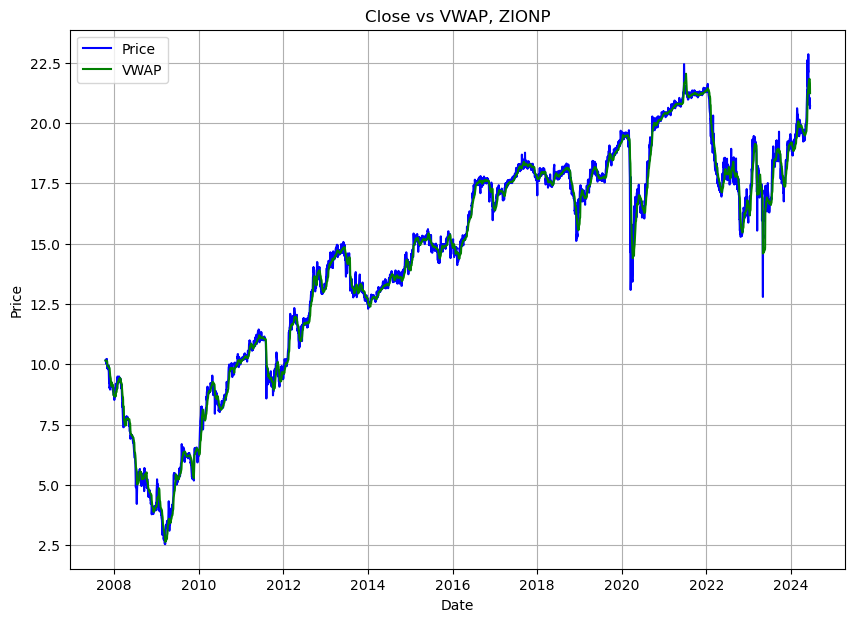

In [14]:
# Create the plot
plt.figure(figsize=(10, 7))  # Set the figure size
plt.plot(df.index, df['Close'], label="Price", color = "blue")
plt.plot(df.index, df['vwap'], label="VWAP", color = 'green')
# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Close vs VWAP, {ticker}")
# Add legend
plt.legend()
# Show the plot
plt.grid(True)
plt.show()